# Based on [this tutorial](https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/)

In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
 
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
 
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

In [5]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

# initialise paths for various resources
dataPath = "dankKnowledge/trainingImages/"
modelPath = 'multiClass.h5'
labelPath = 'mlb.pickle'
plotPath = 'modelPerf.png'

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataPath)))
random.seed(42)
random.shuffle(imagePaths)
 
# initialize the data and labels
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = imagePath.split(os.path.sep)[-2]
    labels.append(l)
    
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
 
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))
    
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)
 
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")
 
# initialize the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)


# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save(modelPath)
 
# save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(labelPath, "wb")
f.write(pickle.dumps(mlb))
f.close()


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(plotPath)



[INFO] loading images...
[INFO] data matrix: 1794 images (387.50MB)
[INFO] class labels:
1. dankKnowledge/trainingImages/bad-luck-brian
2. dankKnowledge/trainingImages/drakePosting
3. dankKnowledge/trainingImages/good-guy-greg
4. dankKnowledge/trainingImages/pepe-the-frog
5. dankKnowledge/trainingImages/scumbagSteve
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
44/44 [==============================] - 139s 3s/step - loss: 0.5034 - acc: 0.8119 - val_loss: 0.4915 - val_acc: 0.8557
Epoch 2/15
44/44 [==============================] - 138s 3s/step - loss: 0.2569 - acc: 0.9134 - val_loss: 0.2476 - val_acc: 0.9315
Epoch 3/15
44/44 [==============================] - 127s 3s/step - loss: 0.2130 - acc: 0.9358 - val_loss: 0.2697 - val_acc: 0.9231
Epoch 4/15
44/44 [==============================] - 147s 3s/step - loss: 0.1652 - acc: 0.9471 - val_loss: 0.1912 - val_acc: 0.9510
Epoch 5/15
44/44 [==============================] - 166s 4s/step - loss: 0.1498 - acc: 0.9530 - val_loss:

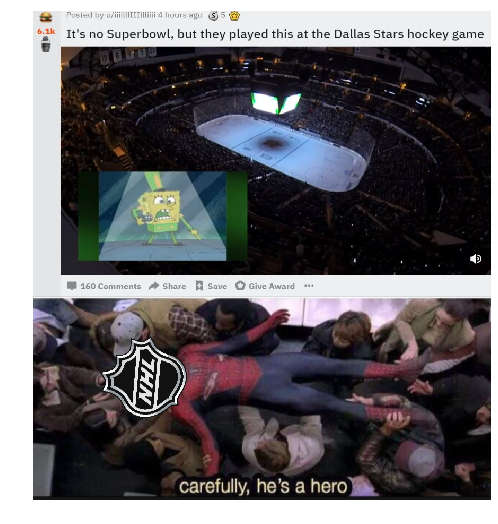

[INFO] loading network...
[INFO] classifying image...
dankKnowledge/trainingImages/bad-luck-brian: 17.26%
dankKnowledge/trainingImages/drakePosting: 0.06%
dankKnowledge/trainingImages/good-guy-greg: 2.42%
dankKnowledge/trainingImages/pepe-the-frog: 12.77%
dankKnowledge/trainingImages/scumbagSteve: 43.02%


In [8]:
%matplotlib inline
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

imPath = "superbowlHero.png"
modelPath = 'multiClass.h5'
labelPath = 'mlb.pickle'

# load the image
image = cv2.imread(imPath)
output = imutils.resize(image, width=400)

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()
 
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# load the trained convolutional neural network and the multi-label
# binarizer
print("[INFO] loading network...")
model = load_model(modelPath)
mlb = pickle.loads(open(labelPath, "rb").read())
 
# classify the input image then find the indexes of the two class
# labels with the *largest* probability
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:2]


# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(idxs):
    # build the label and draw the label on the image
    label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    cv2.putText(output, label, (10, (i * 30) + 25), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
 
# show the probabilities for each of the individual labels
for (label, p) in zip(mlb.classes_, proba):
    print("{}: {:.2f}%".format(label, p * 100))
 
# show the output image